

## Value-at-Risk (VaR) and Conditional VaR (CVaR) Analysis

In this model, I calculate and compare the 1-day Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR) for a hypothetical equally weighted portfolio consisting of AAPL, NVDA, and MSFT. Three methods are used:

* **Historical Simulation:** A non-parametric approach based on the actual distribution of past portfolio returns.
* **Parametric Method:** A parametric approach assuming normally distributed returns.
* **GARCH(1,1) Model:** A time-series model that captures volatility clustering by estimating time-varying conditional variance.

The analysis includes:

* Downloading historical stock prices and computing portfolio returns.
* Testing the normality of returns using the Shapiro-Wilk test.
* Estimating VaR and CVaR at both 95% and 99% confidence levels using all three methods.
* Visualizing the risk measures and comparing results across methods.
* Evaluating the appropriateness of each approach, particularly the limitations of the parametric method when normality is violated.


### 1.  Setup & Data Retrieval


In [1]:
# Install all nescessary libaries
!pip install yfinance pandas numpy matplotlib scipy arch

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro
from arch import arch_model

In [3]:
tickers = ['AAPL', 'NVDA', 'MSFT']
start_date = '2024-01-01'
end_date = '2025-07-01'
weights = np.array([1/3, 1/3, 1/3])
portfolio_value = 1_000_000
confidence_levels = [95, 99]

# Download price data and compute daily returns
prices = yf.download(tickers, start=start_date, end=end_date)['Close']
returns = prices.pct_change().dropna()
portfolio_returns = returns.dot(weights)

/tmp/ipython-input-3-3478676714.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


### 2. Historical VaR & CVaR

The **Historical Method** estimates Value-at-Risk (VaR) and Conditional VaR (CVaR) directly from actual historical return data, without making any distributional assumptions. It sorts past portfolio returns and calculates:

- **VaR** as the percentile corresponding to the desired confidence level (e.g., 5th percentile for 95% confidence).
- **CVaR** as the average of losses beyond the VaR threshold (i.e., in the left tail).

This method captures real market behaviors, including fat tails and skewness, making it robust and widely used.




In [4]:
# Historical VaR & CVaR Functions
def historical_var(returns, level):
    return np.percentile(returns, 100 - level)

def historical_cvar(returns, level):
    cutoff = np.percentile(returns, 100 - level)
    return returns[returns <= cutoff].mean()

In [5]:
# Compute Historical VaR & CVaR
hist_var_dict = {}
hist_cvar_dict = {}

for level in confidence_levels:
    hist_var_dict[level] = historical_var(portfolio_returns, level)
    hist_cvar_dict[level] = historical_cvar(portfolio_returns, level)

# Print results
for level in confidence_levels:
    print(f"{level}% Historical VaR: {hist_var_dict[level]:.4%}, Historical CVaR: {hist_cvar_dict[level]:.4%}")

95% Historical VaR: -2.7611%, Historical CVaR: -4.2162%
99% Historical VaR: -4.8099%, Historical CVaR: -5.6656%


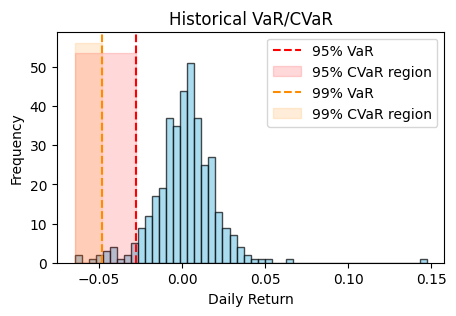

In [6]:
# Plot Historical
def plot_historical_var_cvar_multi(portfolio_returns, var_dict, cvar_dict):
    plt.figure(figsize=(5, 3))
    plt.hist(portfolio_returns, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    colors = {95: 'red', 99: 'darkorange'}
    for level in var_dict:
        plt.axvline(var_dict[level], color=colors[level], linestyle='--', label=f'{level}% VaR')
        plt.fill_betweenx(
            [0, plt.gca().get_ylim()[1]],
            portfolio_returns.min(),
            var_dict[level],
            color=colors[level],
            alpha=0.15,
            label=f'{level}% CVaR region'
        )
    plt.title('Historical VaR/CVaR')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_historical_var_cvar_multi(portfolio_returns, hist_var_dict, hist_cvar_dict)

### 3. Parametric VaR & CVaR

The **Parametric Method** assumes that portfolio returns follow a **normal distribution**. Using this assumption, it analytically computes:

* **VaR** as a quantile of the normal distribution (e.g., -1.645 × σ for 95% confidence).
* **CVaR** as the expected loss beyond the VaR, derived using the properties of the normal distribution.

While computationally efficient, this method can be **misleading if returns are not normally distributed**, especially in the presence of skewness or fat tails. It's important to validate the normality assumption (e.g., with the Shapiro-Wilk test) before relying on this method.

In [7]:
# Check Normality
stat, p = shapiro(portfolio_returns)
print(f"Shapiro-Wilk test: statistic={stat:.4f}, p-value={p:.4f}")
if p < 0.05:
    print("Reject normality assumption (returns are NOT normal)")
else:
    print("Fail to reject normality (returns MAY BE normal)")


Shapiro-Wilk test: statistic=0.9155, p-value=0.0000
Reject normality assumption (returns are NOT normal)


**Note**: The Shapiro-Wilk test indicates a strong rejection of normality (p-value = 0.0000), suggesting the portfolio returns are not normally distributed. As a result, the parametric VaR and CVaR estimates may be inaccurate, and results from the historical method should be prioritized for risk assessment.

In [8]:
# Parametric VaR & CVaR Functions
def parametric_var(std_dev, level):
    z = {95: 1.645, 99: 2.33}[level]
    return -z * std_dev

def parametric_cvar(std_dev, level):
    alpha = (100 - level) / 100
    z = norm.ppf(alpha)
    return -std_dev * (norm.pdf(z) / alpha)

In [9]:
# Compute Parametric VaR & CVaR
cov_matrix = returns.cov()
port_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

para_var_dict = {}
para_cvar_dict = {}

for level in confidence_levels:
    para_var_dict[level] = parametric_var(port_std_dev, level)
    para_cvar_dict[level] = parametric_cvar(port_std_dev, level)

# Print results
for level in confidence_levels:
    print(f"{level}% Parametric VaR: {para_var_dict[level]:.4%}, Parametric CVaR: {para_cvar_dict[level]:.4%}")

95% Parametric VaR: -3.1115%, Parametric CVaR: -3.9016%
99% Parametric VaR: -4.4072%, Parametric CVaR: -5.0413%


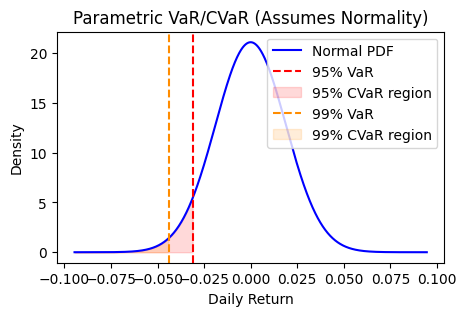

In [10]:
# Plot Parametric
def plot_parametric_var_cvar_multi(std_dev, var_dict, cvar_dict):
    x = np.linspace(-5*std_dev, 5*std_dev, 1000)
    pdf = norm.pdf(x, 0, std_dev)
    plt.figure(figsize=(5, 3))
    plt.plot(x, pdf, label='Normal PDF', color='blue')
    colors = {95: 'red', 99: 'darkorange'}
    for level in var_dict:
        plt.axvline(var_dict[level], color=colors[level], linestyle='--', label=f'{level}% VaR')
        plt.fill_between(x[x <= var_dict[level]], pdf[x <= var_dict[level]], color=colors[level], alpha=0.15, label=f'{level}% CVaR region')
    plt.title('Parametric VaR/CVaR (Assumes Normality)')
    plt.xlabel('Daily Return')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_parametric_var_cvar_multi(port_std_dev, para_var_dict, para_cvar_dict)

### 4. GARCH-based VaR & CVaR

The **GARCH (Generalized Autoregressive Conditional Heteroskedasticity)** model captures **time-varying volatility** often observed in financial returns — volatility clustering, where high-volatility days tend to follow high-volatility days, and similarly for low-volatility days.

By modeling the changing variance of returns over time, GARCH-based VaR estimates are **more responsive to current market conditions** than static parametric VaR. It assumes residuals (standardized returns) are normally or t-distributed, but the volatility estimate adapts dynamically.

- **VaR** is calculated using the GARCH-estimated volatility at the current time point and the chosen quantile of the assumed residual distribution.
- **CVaR** is the expected loss conditional on exceeding VaR, computed from the same dynamic volatility and distribution.

This method provides a more realistic risk estimate under changing market conditions, especially during periods of market stress.


In [11]:
# Fit a GARCH(1,1) model with normal errors
garch_model = arch_model(portfolio_returns * 100, vol='Garch', p=1, q=1, dist='normal')
garch_res = garch_model.fit(disp='off')

In [12]:
#Calculate conditional volatility forecast (in %)
cond_vol = garch_res.conditional_volatility / 100  # convert back to decimal returns scale

# Take the latest conditional volatility as current volatility estimate
current_vol = cond_vol.iloc[-1]

print(f"Latest conditional volatility estimate (daily): {current_vol:.4%}")

Latest conditional volatility estimate (daily): 1.3621%


In [13]:
# GARCH-based VaR and CVaR functions

def garch_parametric_var(current_vol, level):
    z = {95: 1.645, 99: 2.33}[level]
    return -z * current_vol

def garch_parametric_cvar(current_vol, level):
    alpha = (100 - level) / 100
    z = norm.ppf(alpha)
    return -current_vol * (norm.pdf(z) / alpha)

In [14]:
# Compute GARCH-based VaR and CVaR for confidence levels
garch_var_dict = {}
garch_cvar_dict = {}

for level in confidence_levels:
    garch_var_dict[level] = garch_parametric_var(current_vol, level)
    garch_cvar_dict[level] = garch_parametric_cvar(current_vol, level)

# Print results
for level in confidence_levels:
    print(f"{level}% GARCH VaR: {garch_var_dict[level]:.4%}, GARCH CVaR: {garch_cvar_dict[level]:.4%}")

95% GARCH VaR: -2.2406%, GARCH CVaR: -2.8096%
99% GARCH VaR: -3.1736%, GARCH CVaR: -3.6302%


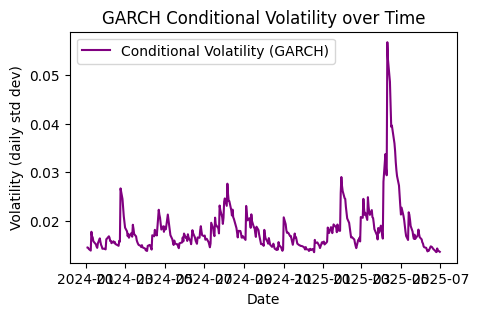

In [15]:
# Plot GARCH-based VaR & CVaR over time
plt.figure(figsize=(5,3))
plt.plot(cond_vol, label='Conditional Volatility (GARCH)', color='purple')
plt.title('GARCH Conditional Volatility over Time')
plt.xlabel('Date')
plt.ylabel('Volatility (daily std dev)')
plt.legend()
plt.show()

### 5. Summarize Results

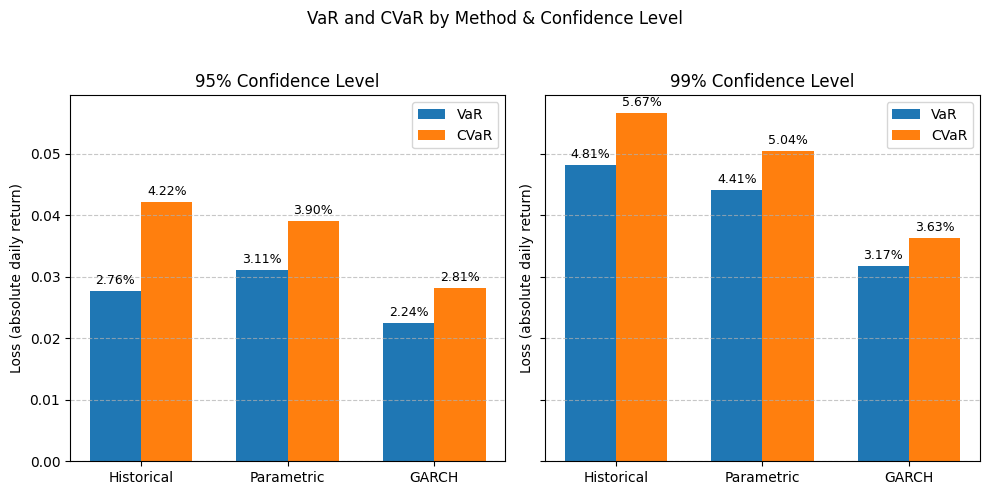

In [16]:
methods = ['Historical', 'Parametric', 'GARCH']

var_data = {
    95: [hist_var_dict[95], para_var_dict[95], garch_var_dict[95]],
    99: [hist_var_dict[99], para_var_dict[99], garch_var_dict[99]]
}

cvar_data = {
    95: [hist_cvar_dict[95], para_cvar_dict[95], garch_cvar_dict[95]],
    99: [hist_cvar_dict[99], para_cvar_dict[99], garch_cvar_dict[99]]
}

bar_width = 0.35
x = np.arange(len(methods))

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for i, level in enumerate(confidence_levels):
    ax = axes[i]
    var_vals = np.abs(var_data[level])
    cvar_vals = np.abs(cvar_data[level])

    bars_var = ax.bar(x - bar_width/2, var_vals, bar_width, label='VaR')
    bars_cvar = ax.bar(x + bar_width/2, cvar_vals, bar_width, label='CVaR')

    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.set_title(f"{level}% Confidence Level")
    ax.set_ylabel("Loss (absolute daily return)")
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add labels on bars
    for bars in [bars_var, bars_cvar]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2%}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # offset label above bar
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

plt.suptitle('VaR and CVaR by Method & Confidence Level')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Comments on VaR & CVaR Results

**1. Normality assumption rejected**
- Since your portfolio returns failed the normality test, the parametric method (which assumes normality) is less reliable and can underestimate or misrepresent tail risks.

**2. Historical VaR and CVaR are more conservative than parametric at 95% and 99%**

- The historical VaR (-2.76% and -4.81%) and CVaR (-4.22% and -5.67%) are generally more negative than the parametric counterparts.

- This suggests the empirical distribution has fatter tails or skewness not captured by the normal distribution assumed in the parametric method.

**3. Parametric VaR is more conservative than GARCH VaR**

- Parametric VaR values are more negative than GARCH VaR, indicating it predicts higher risk than GARCH at these levels.

- But given the violation of normality, this “conservativeness” of parametric VaR might be misleading because it’s not modeling the real tail behavior accurately.

**4. GARCH VaR is less conservative overall**

- GARCH VaR and CVaR are less negative, indicating the model predicts lower tail risk compared to historical and parametric methods.

- GARCH models volatility clustering and conditional heteroskedasticity, which can smooth extreme values but might also underestimate extreme tail events depending on the model fit.